### Description
* In this notebook, we study the seasonality pattern if any in sold house pricing and volume.
* Also try to see if different clusters show similar pattern or not.

In [1]:
%load_ext autoreload
%autoreload 1
import os,sys
import numpy as np
import pandas as pd

src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *
%aimport algorithm
from algorithm import *

import logging
from utils import *
set_logger(logging.WARNING)

### load data
* all transactions (1983~2017.10) and features of properties involved in these transactions
* all properties with 

In [2]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
df_transaction = ds.get_view_df('property_address_school_transactions')
df_property = ds.get_view_df('property_address_schools')
print(df_transaction.shape)
print(df_property.shape)

pp = Preprocess(df_transaction, df_property)
use_features = pp.get_feature_list()
school_features = ['min_elem_distance', 'min_middle_distance', 'min_high_distance',
                   'elem_rating', 'middle_rating', 'high_rating',
                   'avg_elem_rating', 'avg_high_rating', 'avg_middle_rating']
use_features = list(set(use_features ) - set(school_features))
df_all = pp.dataset(feature='all', valid=True)

(1477830, 37)
(710576, 34)


### process data
* get monthly volume and price

In [13]:
df_all['sold_month'] = df_all['date'].dt.month
monthly_volume = df_all.groupby(by=['sold_year', 'sold_month'])['sqft_price'].count().unstack(level=-1)
monthly_price = df_all.groupby(by=['sold_year', 'sold_month'])['sqft_price'].median().unstack(level=-1)

In [30]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
monthly_volume_norm = min_max_scaler.fit_transform(monthly_volume.dropna(axis=0).T).T
monthly_price_norm = min_max_scaler.fit_transform(monthly_price.dropna(axis=0).T).T

### visualization
* heatmap with yearly and monthly volume and price.

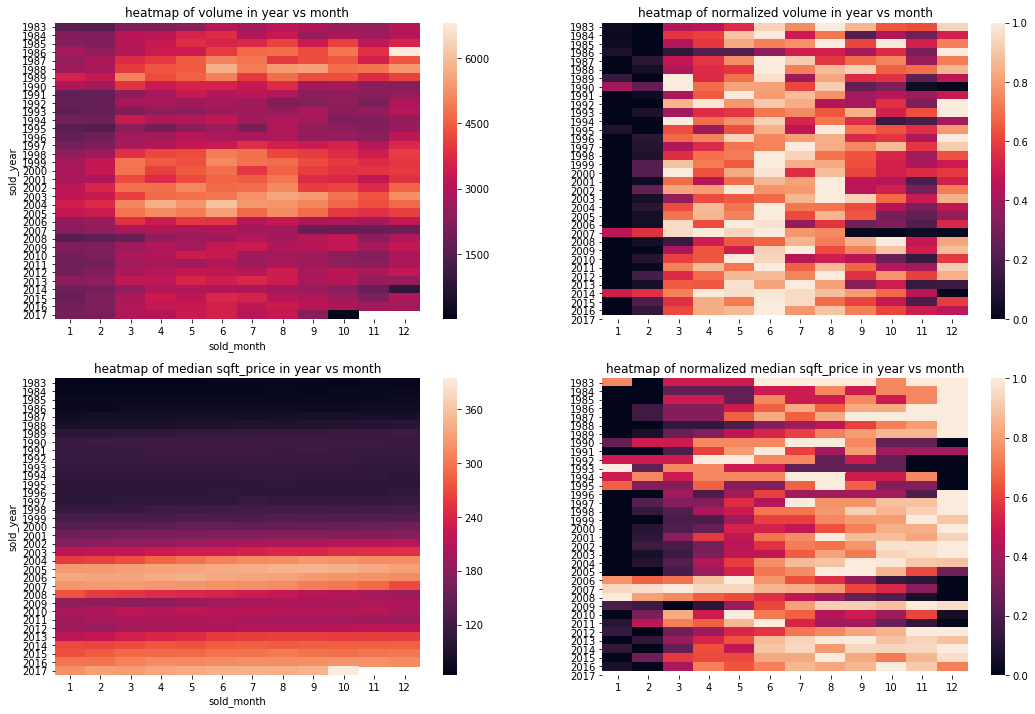

In [31]:
fig,ax = plt.subplots(2, 2, figsize=(18, 12))
sns.heatmap(monthly_volume, ax=ax[0,0], xticklabels=np.arange(1,13,1), yticklabels=np.arange(1983,2018,1))
ax[0,0].set_title('heatmap of volume in year vs month')
sns.heatmap(monthly_volume_norm, ax=ax[0,1], xticklabels=np.arange(1,13,1), yticklabels=np.arange(1983,2018,1))
ax[0,1].set_title('heatmap of normalized volume in year vs month')
sns.heatmap(monthly_price, ax=ax[1,0], xticklabels=np.arange(1,13,1), yticklabels=np.arange(1983,2018,1))
ax[1,0].set_title('heatmap of median sqft_price in year vs month')
sns.heatmap(monthly_price_norm, ax=ax[1,1], xticklabels=np.arange(1,13,1), yticklabels=np.arange(1983,2018,1))
ax[1,1].set_title('heatmap of normalized median sqft_price in year vs month')
plt.show()

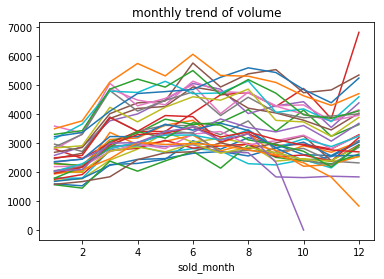

In [37]:
monthly_volume.T.plot(title='monthly trend of volume', legend=False)

#### Findings
* The volume is at bottom during Jan. Feb, keep improving in spring, reach peak around late spring to early summer, and then start to drop.
* It's a bit interesting that volume is a little back in Dec. 
* It's not consistent through years which month is the peak, but generally peak is within May. ~ Aug.

### check if different clusters have same pattern or not

In [77]:
df_clusters = pd.read_json('c:\projects\sdra\public\json\zip_clusters.json')
cluster_methods = df_clusters.columns
df_clusters['zip'] = df_clusters.index.astype(str)
df_all_cluster = df_all.merge(df_clusters, on='zip')

method: cluster_on_sqft_price


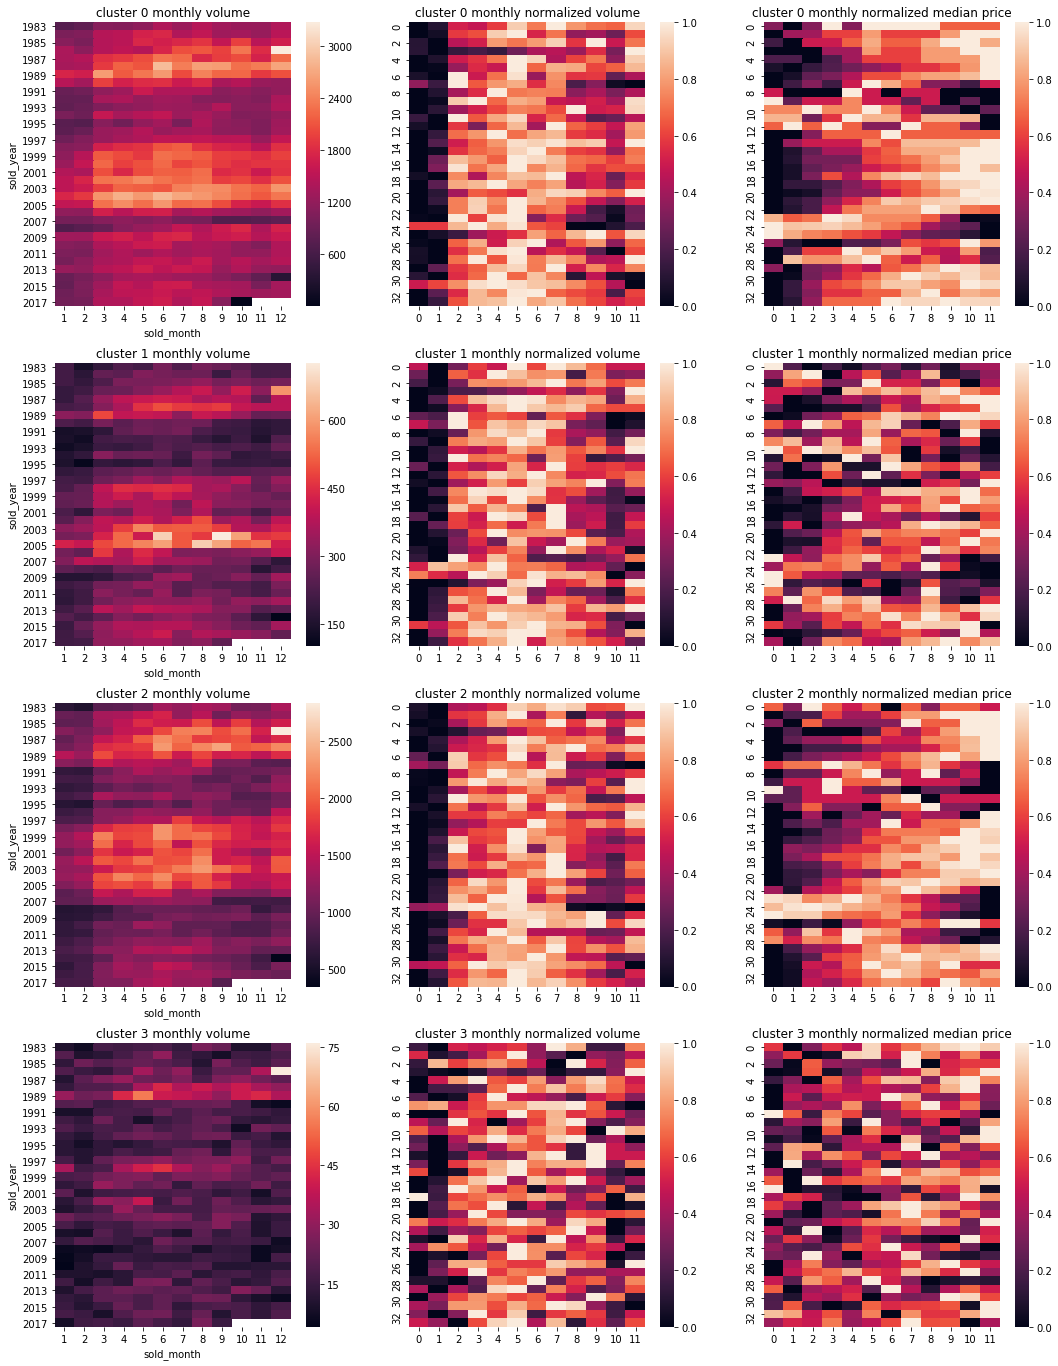

method: cluster_on_sqft_price_diff


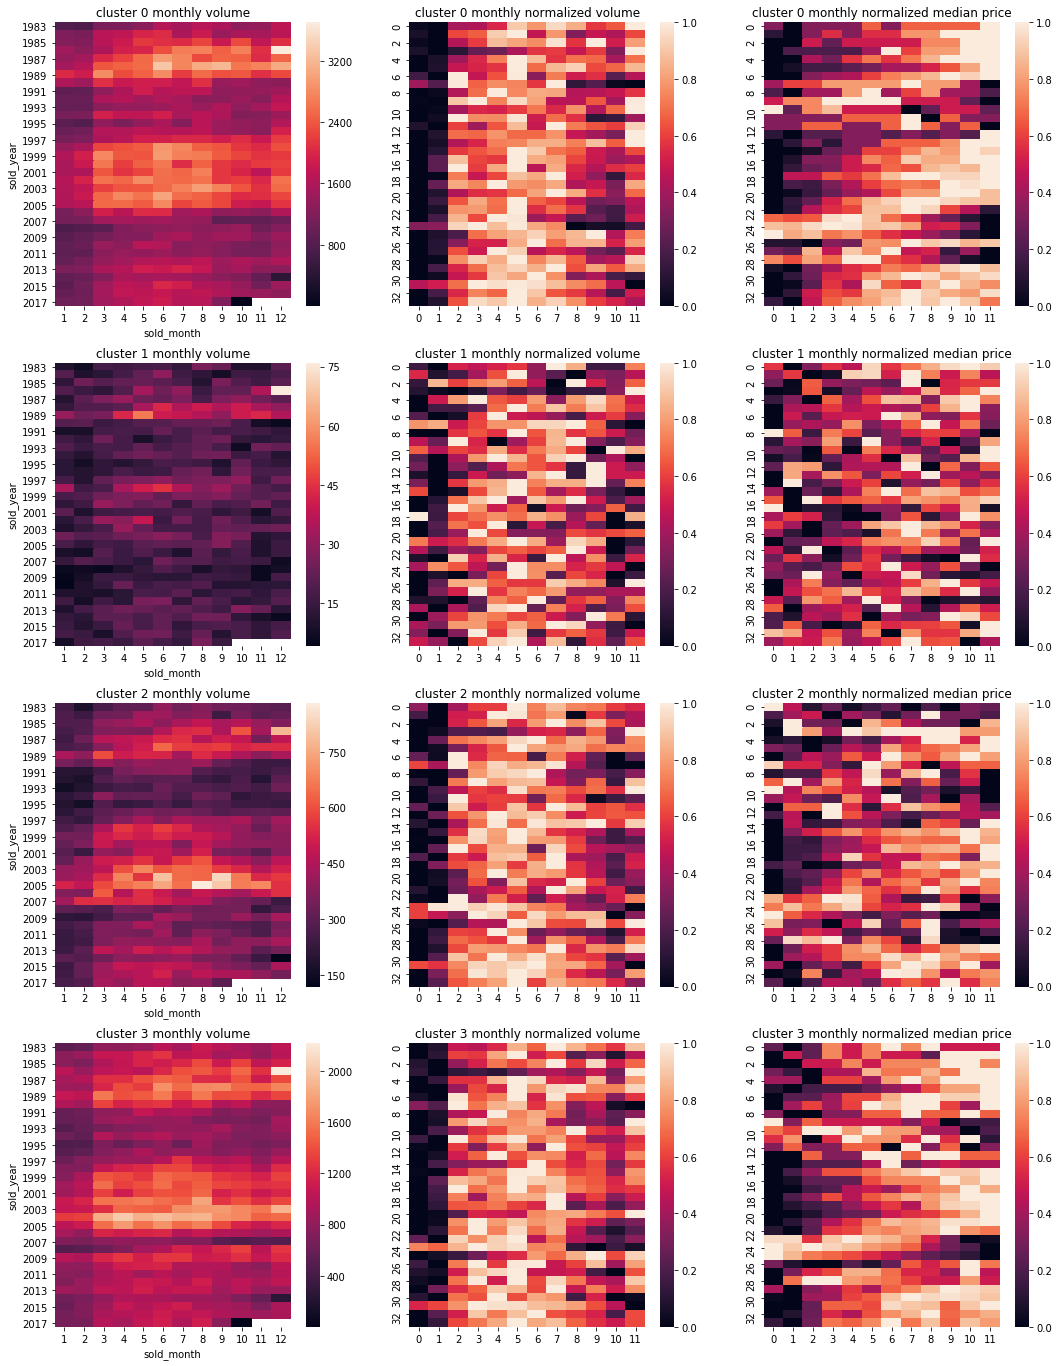

method: cluster_on_sqft_price_yoy


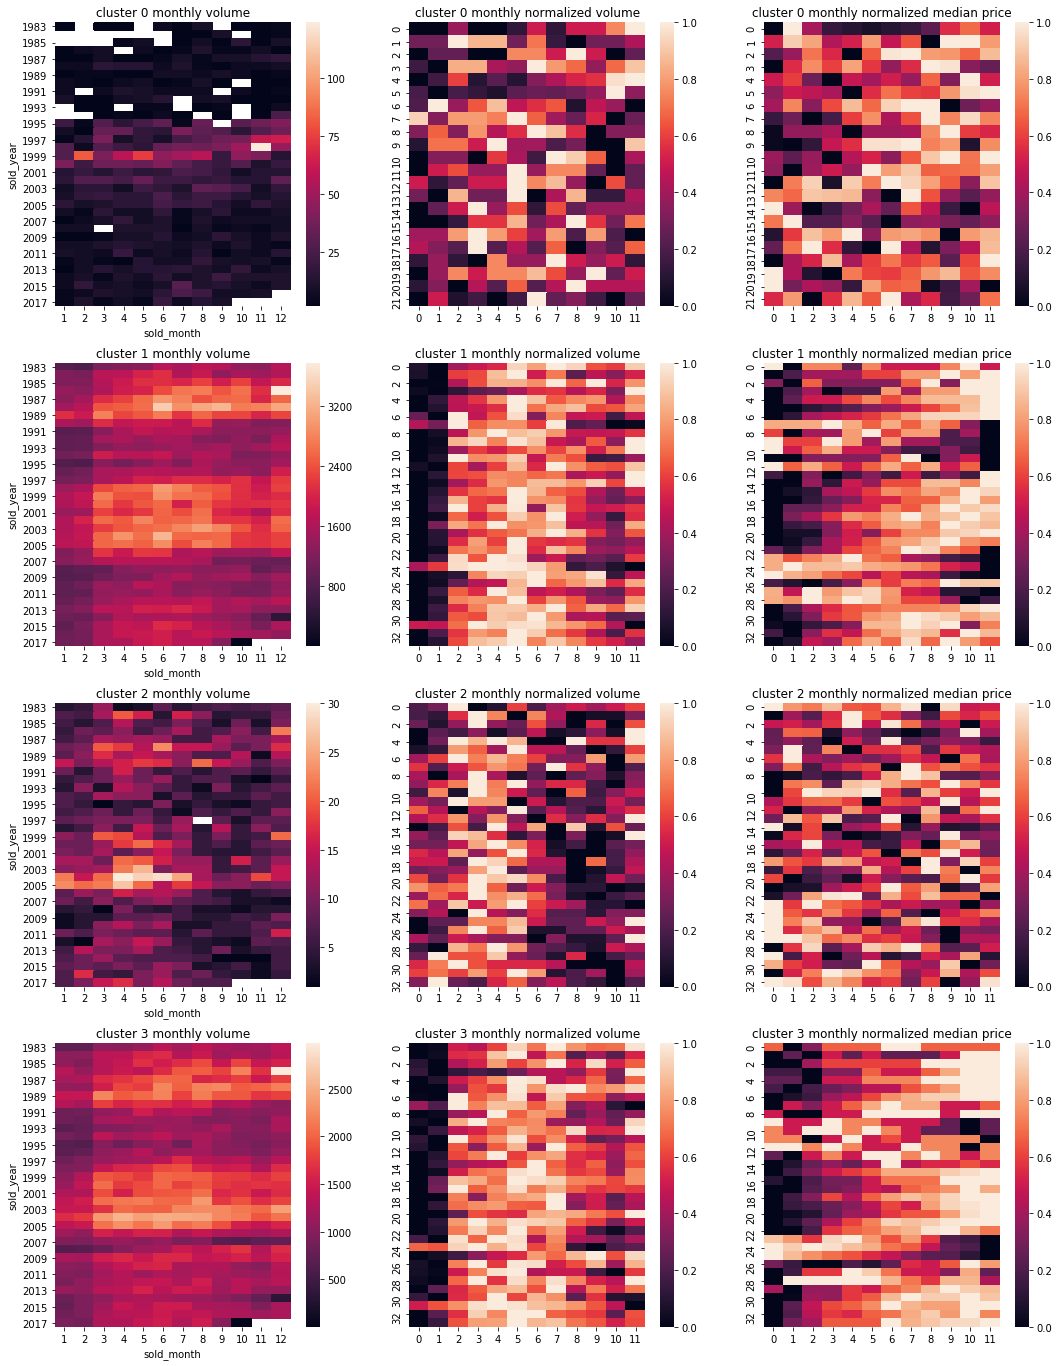

method: cluster_on_volume


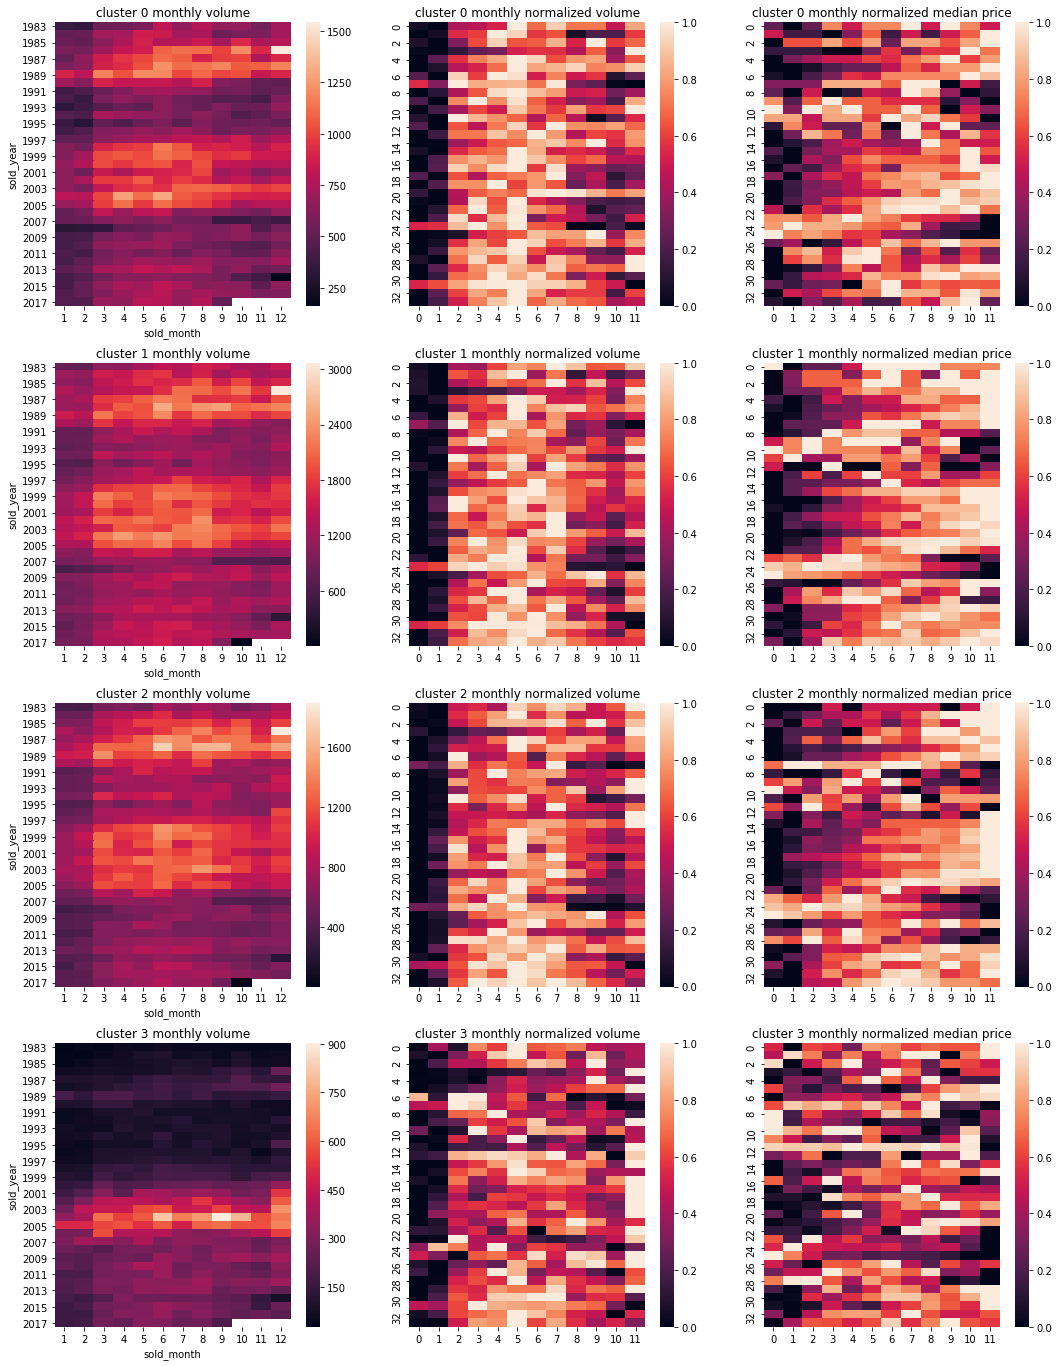

In [84]:
for m in cluster_methods:
    monthly_volume = df_all_cluster.groupby(by=[m, 'sold_year', 'sold_month'])['sqft_price'].count().unstack(level=-1)
    monthly_price = df_all_cluster.groupby(by=[m, 'sold_year', 'sold_month'])['sqft_price'].median().unstack(level=-1)

    n_cluster = df_clusters[m].max()+1
    fig,ax = plt.subplots(n_cluster, 3, figsize=(18, n_cluster*6))
    print('method:', m)
    for i in range(n_cluster):
        ax[i,0].set_title('cluster {} monthly volume'.format(i))
        sns.heatmap(monthly_volume.loc[i], ax=ax[i,0])
        
        monthly_volume_norm = min_max_scaler.fit_transform(monthly_volume.loc[i].dropna(axis=0).T).T
        ax[i,1].set_title('cluster {} monthly normalized volume'.format(i))
        sns.heatmap(monthly_volume_norm, ax=ax[i,1])
        
        monthly_price_norm = min_max_scaler.fit_transform(monthly_price.loc[i].dropna(axis=0).T).T
        ax[i,2].set_title('cluster {} monthly normalized median price'.format(i))
        sns.heatmap(monthly_price_norm, ax=ax[i,2])
    plt.show()

#### conclusion
* The patterns found in previous section are consistent in various clusters. Note: those cluster showing random patterns have very small volume.
* Not much difference in seasonality found between clusters